In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon 
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import itertools

In [314]:
input_dir = "Results" # input directory

number = "L" # results to analyze (subfolder name, can be an integer or string)

recording_order = (15, 2, 1, 6, 10, 4)

In [315]:
dfs = {}

results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('OVERVIEW')]

for file in files:
    file_path = os.path.join(results_dir, file)
    dfs[file.split('.')[0]] = pd.read_excel(file_path)

framenames = list(dfs.keys())
results = framenames[0]
results_mtt = framenames[1]
results_tt = framenames[2]

print(f"Found {framenames} in {results_dir}.")

framenames.append('RESULTS_MERGED')
framenames.append('RESUlTS_MERGED_MTT')
framenames.append('RESULTS_MERGED_TT')

Found ['RESULTS', 'RESULTS_MTT', 'RESULTS_TT'] in Results\L.


In [316]:
experiments = dfs[results]['experiment'].unique().tolist()
variables = dfs[results].columns[4:].tolist()
parameters = dfs[results].columns[:4].tolist()
print(f"Found {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Found 8 experiments, 7 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50
 reactionTime, peakTime, difference, peakValue, RMS, tau, AUC
 animal, sex, date, experiment


In [317]:
def average_list_columns(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Try to convert string representations of lists to actual lists
        if df_copy[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
            df_copy[col] = df_copy[col].apply(
                lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else np.mean(x) if isinstance(x, list) else x
            )
    return df_copy

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

In [318]:
def average_across_dates(df):
    # Group by all columns except 'date' and the variables, then average variables across dates
    group_cols = [col for col in df.columns if col not in variables and col != 'date']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])

In [319]:
print(list(dfs.keys()))

['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'RESULTS_MERGED', 'RESULTS_MTT_MERGED', 'RESULTS_TT_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE']


# Distributions

In [320]:
non_parametric_dfs = {}
for name, df in dfs.items():
    print(name)
    if not name.endswith('_MERGED'):
        continue  # Only process merged dataframes
    non_parametric = pd.DataFrame(columns=['experiment', 'var'])
    not_enough_data = 0
    for var in variables:
        for exp in experiments:
            for sex in ['male', 'female']:
                data = df[(df['sex'] == sex) & (df['experiment'] == exp)][var].dropna()
                if len(data) > 2:
                    stat, p = shapiro(data)
                    if p < 0.05:
                        non_parametric = pd.concat(
                            [non_parametric, pd.DataFrame({'experiment': [exp], 'var': [var]})],
                            ignore_index=True
                        )
                else:
                    not_enough_data += 1
    non_parametric_dfs[name] = non_parametric
    #print(f"Non-parametric entries in {name}: {len(non_parametric)}")
    #if not_enough_data != 0: print(f"Warning, not enough data for {not_enough_data} entries.")

RESULTS
RESULTS_MTT
RESULTS_TT
RESULTS_MERGED
RESULTS_MTT_MERGED
RESULTS_TT_MERGED
RESULTS_MERGED_DATE
RESULTS_MTT_MERGED_DATE
RESULTS_TT_MERGED_DATE


c:\Users\Galahad\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [321]:
print(len(non_parametric_dfs['RESULTS_MERGED']))
print(len(non_parametric_dfs['RESULTS_MTT_MERGED']))
print(len(non_parametric_dfs['RESULTS_TT_MERGED']))

20
20
22


### Expand non-parametric tests to all variations of gap duration or offset PPI if one of the variations shows significant deviations from normality

In [322]:
gap_durations = ['gap_duration_4', 'gap_duration_8', 'gap_duration_10', 'gap_duration_20', 'gap_duration_50']
offset_exps = [exp for exp in dfs[results]['experiment'].unique() if 'offset_PPI' in str(exp).lower()]

# Concatenate and drop duplicates as before
dfs_to_merge = [
    non_parametric_dfs['RESULTS_MERGED'],
    non_parametric_dfs['RESULTS_MTT_MERGED'],
    non_parametric_dfs['RESULTS_TT_MERGED']
]
non_parametric = pd.concat(dfs_to_merge, ignore_index=True).drop_duplicates()

# Extend: for each row with "gap_duration" in experiment, add all gap_duration_* for that var
rows_to_add = []
for _, row in non_parametric.iterrows():
    if "gap_duration" in row['experiment']:
        for gap_exp in gap_durations:
            if gap_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = gap_exp
                rows_to_add.append(new_row)
    if "offset_PPI" in row['experiment']:
        for offset_exp in offset_exps:
            if offset_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = offset_exp
                rows_to_add.append(new_row)


# Add the new rows and drop duplicates again
if rows_to_add:
    non_parametric = pd.concat([non_parametric, pd.DataFrame(rows_to_add)], ignore_index=True).drop_duplicates()

#print(non_parametric)

## Analysis

In [323]:
# test order depends on each previous result (as in if we can't merge across days, then use date_df for rest, for example)

# compare date df to df     -> DONE
# compare top_10 df to minus_top_10 df      -> DONE

# compare across reps       -> DONE

# compare strength metrics between males and females        -> DONE
# compare reaction time metrics between males and females       -> DONE

# compare time of day (i.e. animal number in order 15, 2, 1, 6, 10, 4) for all metrics      -> DONE

# compare experiment for all metrics        -> DONE

In [324]:
def compare_metrics(df1, df2, variables, group_cols=None, test='auto', non_parametric=None, alpha=0.05):
    """
    Compare all metrics (variables) in df1 to df2.
    If group_cols is provided, compare within each group.
    test: 'auto' (choose t-test or Mann-Whitney based on normality or non_parametric list), 'ttest', or 'mannwhitney'
    non_parametric: DataFrame with columns ['experiment', 'var'] indicating which (experiment, variable) pairs to use non-parametric test for.
    alpha: significance threshold for p-value.
    Returns a DataFrame with only significant results.
    """
    results = []
    if group_cols is None:
        group_cols = []
    for var in variables:
        if group_cols:
            groups = df1[group_cols].drop_duplicates()
            for _, group_vals in groups.iterrows():
                group_dict = group_vals.to_dict()
                mask1 = np.ones(len(df1), dtype=bool)
                mask2 = np.ones(len(df2), dtype=bool)
                for col in group_cols:
                    mask1 &= (df1[col] == group_dict[col])
                    mask2 &= (df2[col] == group_dict[col])
                vals1 = df1.loc[mask1, var].dropna()
                vals2 = df2.loc[mask2, var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    print(f"Not enough data for {var} in group {group_dict}.")
                    continue
                is_non_parametric = False
                if non_parametric is not None:
                    experiment = group_dict['experiment'] if 'experiment' in group_cols else None
                    if experiment is not None:
                        is_non_parametric = ((non_parametric['experiment'] == experiment) & (non_parametric['var'] == var)).any()
                if test == 'auto':
                    if is_non_parametric:
                        stat, p = mannwhitneyu(vals1, vals2)
                        test_used = 'mannwhitney'
                    else:
                        stat, p = ttest_ind(vals1, vals2)
                        test_used = 'ttest'
                elif test == 'ttest':
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
                else:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                if p < alpha:
                    results.append({**group_dict, 'variable': var, 'stat': stat, 'p': p, 'test': test_used})
        else:
            vals1 = df1[var].dropna()
            vals2 = df2[var].dropna()
            if len(vals1) < 2 or len(vals2) < 2:
                print(f"Not enough data for {var} in either group.")
                continue
            is_non_parametric = False
            if non_parametric is not None:
                is_non_parametric = (non_parametric['var'] == var).any()
            if test == 'auto':
                if is_non_parametric:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                else:
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
            elif test == 'ttest':
                stat, p = ttest_ind(vals1, vals2)
                test_used = 'ttest'
            else:
                stat, p = mannwhitneyu(vals1, vals2)
                test_used = 'mannwhitney'
            if p < alpha:
                results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

In [325]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MERGED'],
    dfs['RESULTS_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

No significant differences found for date-averaged comparison.


### -> we can merge across dates

In [326]:
# Average across animals, dates, and experiments for both top 10 and minus top 10 DataFrames
def average_all(df, variables):
    # Remove columns not needed for grouping (keep only variables)
    return pd.DataFrame(df[variables].mean()).T

# Prepare the two DataFrames (replace with your actual keys if different)
top10_df = dfs['RESULTS_TT_MERGED_DATE']
minus_top10_df = dfs['RESULTS_MTT_MERGED_DATE']

# Average across all grouping columns (animals, dates, experiments)
top10_avg = average_all(top10_df, variables)
minus_top10_avg = average_all(minus_top10_df, variables)

# Compare all variables between the two averaged DataFrames
results = []
for var in variables:
    vals1 = top10_df[var].dropna()
    vals2 = minus_top10_df[var].dropna()
    # Use Mann-Whitney if either group is non-normal, else t-test (simple rule)
    try:
        if len(vals1) < 2 or len(vals2) < 2:
            print(f"Not enough data for {var} in either group.")
            continue
        _, p1 = shapiro(vals1) if len(vals1) > 3 else (None, 1)
        _, p2 = shapiro(vals2) if len(vals2) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals1, vals2)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals1, vals2)
            test_used = 'ttest'
        if p < 0.05:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    except Exception as e:
        print(f"Error comparing {var}: {e}")

comparison_df_top10 = pd.DataFrame(results)
print(comparison_df_top10 if not comparison_df_top10.empty else "No significant differences found between top 10 and minus top 10 averages.")  

No significant differences found between top 10 and minus top 10 averages.


### -> we can merge top 10 with the rest

In [327]:
# Test if the index within lists (i.e., trial order) affects each variable in 'RESULTS'
from scipy.stats import f_oneway, kruskal

def test_list_index_effect(df, variables, max_index=10, alpha=0.05):
    """
    For each variable, tests if the value changes significantly across list indices (trial order).
    Only prints significant results.
    """
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            raise ValueError(f"No valid list data found for variable: {var}")
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_index)  # Limit to max_index if desired
        # Gather values by index
        index_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                index_groups.append(group.values)
        if len(index_groups) < 2:
            print(f"Not enough groups for {var} (split by sex)")
            continue
        # Use Kruskal-Wallis (non-parametric) or ANOVA (parametric) depending on normality
        # Here, we use Kruskal-Wallis for robustness
        stat, p = kruskal(*index_groups)
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal'})
    return pd.DataFrame(results)

significant_index_effects = test_list_index_effect(dfs['RESULTS'], variables)
print(significant_index_effects if not significant_index_effects.empty else "No significant index effects found for any variable.")

No significant index effects found for any variable.


### -> we can merge across repetitions

In [328]:
# Define metric groups
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def compare_male_female(df, metrics, alpha=0.05):
    results = []
    for var in metrics:
        if var not in df.columns:
            raise ValueError(f"Missing column: {var}")
        vals_male = df[df['sex'] == 'male'][var].dropna()
        vals_female = df[df['sex'] == 'female'][var].dropna()
        if len(vals_male) < 2 or len(vals_female) < 2:
            print(f"Not enough groups for {var} (split by sex)")
            continue
        # Normality check
        _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
        _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals_male, vals_female)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals_male, vals_female)
            test_used = 'ttest'
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

df = dfs['RESULTS_MERGED_DATE']

print("Significant differences between males and females (Strength Metrics):")
strength_results = compare_male_female(df, strength_metrics)
print(strength_results if not strength_results.empty else "None found.")

print("\nSignificant differences between males and females (Reaction Metrics):")
reaction_results = compare_male_female(df, reaction_metrics)
print(reaction_results if not reaction_results.empty else "None found.")

Significant differences between males and females (Strength Metrics):
    variable        stat             p         test
0  peakValue  557.000000  3.085284e-08  mannwhitney
1        RMS  502.000000  1.071114e-05  mannwhitney
2        tau   -7.684638  8.658899e-10        ttest
3        AUC  453.000000  6.940145e-04  mannwhitney

Significant differences between males and females (Reaction Metrics):
None found.


### -> split by sex for strength
### -> merge for reaction time

In [329]:
# Test if experiment type has an influence on strength and reaction time metrics, splitting by sex for strength

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MERGED_DATE']

print("Effect of experiment type on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df_exp[df_exp['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Missing column: {var}")
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            print(f"Not enough groups for {var} ({sex})")
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            print(f"{var} ({sex}): stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics (all animals):")
for var in reaction_metrics:
    if var not in df_exp.columns:
        raise ValueError(f"Missing column: {var}")
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        print(f"Not enough groups for {var} (all animals)")
        continue
    stat, p = kruskal(*groups)
    if p < 0.05:
        print(f"{var}: stat={stat:.3f}, p={p:.3g}")

Effect of experiment type on strength metrics (split by sex):

Effect of experiment type on reaction metrics (all animals):


### -> no effect of experiment type on any variable

In [330]:
# Test if experiment type has an influence on strength and reaction time metrics (no sex split)
# Uses parametric (ANOVA) if all groups are normal, otherwise non-parametric (Kruskal-Wallis)

from scipy.stats import shapiro, f_oneway, kruskal

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

print("Effect of experiment type on strength metrics (all animals):")
for var in strength_metrics:
    if var not in df_exp.columns:
        raise ValueError(f"Missing column: {var}")
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        print(f"Not enough groups for {var} (all animals)")
        continue
    if group_normality(groups):
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics (all animals):")
for var in reaction_metrics:
    if var not in df_exp.columns:
        raise ValueError(f"Missing column: {var}")
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        print(f"Not enough groups for {var} (all animals)")
        continue
    if group_normality(groups):
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}") 

Effect of experiment type on strength metrics (all animals):

Effect of experiment type on reaction metrics (all animals):
reactionTime: ANOVA stat=2.382, p=0.0391


In [331]:
# ...existing code...

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Only run post hoc if ANOVA was significant for reactionTime
if 'reactionTime' in df_exp.columns:
    # Drop NaNs and get relevant columns
    posthoc_df = df_exp[['experiment', 'reactionTime']].dropna()
    # Tukey HSD
    tukey = pairwise_tukeyhsd(posthoc_df['reactionTime'], posthoc_df['experiment'], alpha=0.05)
    print("\nTukey HSD post hoc for reactionTime by experiment:")
    print(tukey.summary())
    # Effect direction: print group means
    means = posthoc_df.groupby('experiment')['reactionTime'].mean()
    print("Means by experiment:", means.to_dict())
# ...existing code...


Tukey HSD post hoc for reactionTime by experiment:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
    ASR_control       gap_depth    -0.65 0.8504 -2.1306 0.8306  False
    ASR_control gap_duration_10  -0.3778 0.9912 -1.8584 1.1029  False
    ASR_control gap_duration_20  -0.5389 0.9376 -2.0195 0.9418  False
    ASR_control  gap_duration_4  -0.3667 0.9926 -1.8473  1.114  False
    ASR_control gap_duration_50  -0.3278 0.9963 -1.8084 1.1529  False
    ASR_control  gap_duration_8  -0.1944 0.9999 -1.6751 1.2862  False
    ASR_control   tone_in_noise  -1.6667 0.0179 -3.1473 -0.186   True
      gap_depth gap_duration_10   0.2722 0.9989 -1.2084 1.7529  False
      gap_depth gap_duration_20   0.1111    1.0 -1.3695 1.5918  False
      gap_depth  gap_duration_4   0.2833 0.9985 -1.1973  1.764  False
      gap_depth gap_duration_50   0.32

ASR_control vs. tone_in_noise (meandiff = -1.67, p-adj = 0.0179, reject = True) <br>
"tone_in_noise" has the lowest mean reaction time, and is significantly different from "ASR_control".

In [332]:
# Test if experiment type has an influence on strength and reaction time metrics, split by sex for both

from scipy.stats import shapiro, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

for sex in ['male', 'female']:
    print(f"\nEffect of experiment type on strength metrics ({sex}):")
    df_sex = df_exp[df_exp['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            print(f"Missing column: {var}")
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            print(f"Not enough groups for {var} ({sex})")
            continue
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

    print(f"\nEffect of experiment type on reaction metrics ({sex}):")
    for var in reaction_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Missing column: {var}")
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            print(f"Not enough groups for {var} ({sex})")
            continue
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
            # Post hoc Tukey HSD if ANOVA
            if test_used == "ANOVA":
                posthoc_df = df_sex[['experiment', var]].dropna()
                tukey = pairwise_tukeyhsd(posthoc_df[var], posthoc_df['experiment'], alpha=0.05)
                print(f"\nTukey HSD post hoc for {var} by experiment ({sex}):")
                print(tukey.summary())
                means = posthoc_df.groupby('experiment')[var].mean()


Effect of experiment type on strength metrics (male):

Effect of experiment type on reaction metrics (male):

Effect of experiment type on strength metrics (female):

Effect of experiment type on reaction metrics (female):


...but if we split by sex, this effect vanishes

### -> no real effect of experiment type on any variable

In [333]:
# Create a DataFrame averaged across experiments within animals (no date column)
df = dfs['RESULTS_MERGED_DATE']
variables = [col for col in df.columns if col not in ['animal', 'sex', 'experiment']]

# Group by animal and sex, then average variables across experiments
RESULTS_MERGED_DATE_EXP = df.groupby(['animal', 'sex'], as_index=False)[variables].mean()

dfs['RESULTS_MERGED_DATE_EXP'] = RESULTS_MERGED_DATE_EXP

print("Created RESULTS_MERGED_DATE_EXP with shape:", RESULTS_MERGED_DATE_EXP.shape)
print(RESULTS_MERGED_DATE_EXP.head())

Created RESULTS_MERGED_DATE_EXP with shape: (6, 9)
     animal     sex  reactionTime   peakTime  difference   peakValue  \
0   Animal1  female     11.516667  30.758333   19.241667   74.972917   
1  Animal10  female      9.791667  30.908333   21.116667   97.404167   
2  Animal15    male     10.504167  31.304167   20.800000  186.056944   
3   Animal2    male      9.925000  32.405556   22.480556  186.800000   
4   Animal4    male     10.066667  28.262500   18.195833  123.687500   

         RMS         tau           AUC  
0  20.570375  169.579792   8705.042104  
1  27.373146  160.301667  11522.484125  
2  48.892437  136.841583  18846.249903  
3  48.009785  125.583181  17238.184972  
4  27.853646   97.080687   9447.599375  


In [334]:
# Compare the effect of recording_order (animal order) on strength and reaction metrics, split by sex for both
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def extract_animal_number(animal_str):
    # Extracts the number from 'Animal15' -> 15
    if isinstance(animal_str, str) and animal_str.lower().startswith('animal'):
        return int(''.join(filter(str.isdigit, animal_str)))
    return np.nan

df = dfs['RESULTS_MERGED_DATE_EXP'].copy()
df['animal_num'] = df['animal'].apply(extract_animal_number)

# Only keep animals in the recording_order
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

print("Effect of recording order on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Missing column: {var}")
        # Group by recording order
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            print(f"Not enough groups for {var} ({sex})")
            continue
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of recording order on reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Missing column: {var}")
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            print(f"Not enough groups for {var} ({sex})")
            continue
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

Effect of recording order on strength metrics (split by sex):
Not enough groups for peakValue (male)
Not enough groups for RMS (male)
Not enough groups for tau (male)
Not enough groups for AUC (male)
Not enough groups for peakValue (female)
Not enough groups for RMS (female)
Not enough groups for tau (female)
Not enough groups for AUC (female)

Effect of recording order on reaction metrics (split by sex):
Not enough groups for reactionTime (male)
Not enough groups for peakTime (male)
Not enough groups for difference (male)
Not enough groups for reactionTime (female)
Not enough groups for peakTime (female)
Not enough groups for difference (female)


### -> keep split by experiment to avoid lacking group size

In [335]:
# Compare the effect of recording_order (animal order) on strength and reaction metrics, split by sex for both

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def extract_animal_number(animal_str):
    # Extracts the number from 'Animal15' -> 15
    if isinstance(animal_str, str) and animal_str.lower().startswith('animal'):
        return int(''.join(filter(str.isdigit, animal_str)))
    return np.nan

df = dfs['RESULTS_MERGED_DATE'].copy()
df['animal_num'] = df['animal'].apply(extract_animal_number)

# Only keep animals in the recording_order
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

print("Effect of recording order on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        # Group by recording order
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        # Check if this variable should be non-parametric for any experiment in this sex
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            # Use the first experiment name in the group (if available)
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        else:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of recording order on reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        else:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

Effect of recording order on strength metrics (split by sex):
peakValue (male): ANOVA stat=44.094, p=3.04e-08
RMS (male): ANOVA stat=48.562, p=1.33e-08
tau (male): ANOVA stat=41.245, p=5.33e-08
AUC (male): ANOVA stat=55.988, p=3.83e-09
peakValue (female): ANOVA stat=15.351, p=7.79e-05
RMS (female): ANOVA stat=10.820, p=0.000589
tau (female): ANOVA stat=32.518, p=3.71e-07
AUC (female): ANOVA stat=7.906, p=0.00276

Effect of recording order on reaction metrics (split by sex):
reactionTime (male): Kruskal-Wallis stat=7.483, p=0.0237
peakTime (male): Kruskal-Wallis stat=13.138, p=0.0014
difference (male): Kruskal-Wallis stat=10.373, p=0.00559
reactionTime (female): Kruskal-Wallis stat=14.613, p=0.000671
difference (female): Kruskal-Wallis stat=6.289, p=0.0431


### -> Significant influence of recording order / time of day on strength and reaction time

In [336]:
# Post hoc test: Dunn's test for pairwise comparisons between recording orders, with effect direction and strength
import scikit_posthocs as sp

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

print("Post hoc Dunn's test for strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Missing column: {var}")
        # Only test if there was a significant Kruskal-Wallis result before
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            print(f"Not enough groups for {var} (split by sex)")
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            # Dunn's test
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            # Effect direction and strength: print group means
            means = df_sex.groupby('rec_order')[var].mean()
            print("Means by rec_order:", means.to_dict())

print("\nPost hoc Dunn's test for reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Missing column: {var}")
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            print(f"Not enough groups for {var} (split by sex)")
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            means = df_sex.groupby('rec_order')[var].mean()
            print("Means by rec_order:", means.to_dict())

Post hoc Dunn's test for strength metrics (split by sex):

peakValue (male):
          0        1         5
0  1.000000  1.00000  0.004943
1  1.000000  1.00000  0.000810
5  0.004943  0.00081  1.000000
Means by rec_order: {0: 186.05694444444447, 1: 186.8, 5: 123.6875}

RMS (male):
          0         1         5
0  1.000000  1.000000  0.002066
1  1.000000  1.000000  0.002066
5  0.002066  0.002066  1.000000
Means by rec_order: {0: 48.8924375, 1: 48.00978472222222, 5: 27.853645833333335}

tau (male):
          0         1         5
0  1.000000  0.471898  0.000123
1  0.471898  1.000000  0.021629
5  0.000123  0.021629  1.000000
Means by rec_order: {0: 136.84158333333335, 1: 125.58318055555554, 5: 97.0806875}

AUC (male):
          0         1         5
0  1.000000  0.966596  0.000302
1  0.966596  1.000000  0.011226
5  0.000302  0.011226  1.000000
Means by rec_order: {0: 18846.249902777778, 1: 17238.18497222222, 5: 9447.599375}

peakValue (female):
          2         3         4
2  1.000000

### -> generally: decrease in strength, increase in reaction time across day
Order effects are strong and consistent: Animals recorded later in the session have lower strength and reaction metrics. <br>
Effect is present in both sexes, but the specific rec_order pairs differ.


Mean Strength metrics by recording order (rec_order):
peakValue (male): {0: 186.05694444444447, 1: 186.8, 5: 123.6875}
peakValue (female): {2: 74.97291666666666, 3: 108.85833333333333, 4: 97.40416666666667}


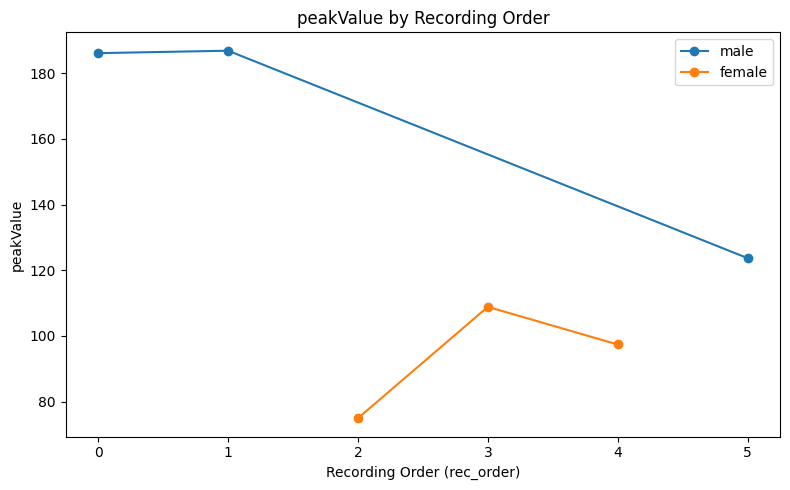

RMS (male): {0: 48.8924375, 1: 48.00978472222222, 5: 27.853645833333335}
RMS (female): {2: 20.570375, 3: 29.037499999999998, 4: 27.373145833333332}


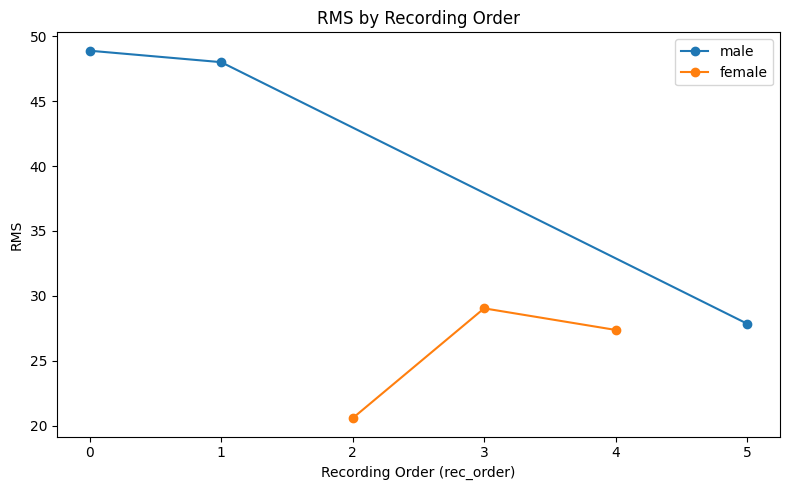

tau (male): {0: 136.84158333333335, 1: 125.58318055555554, 5: 97.0806875}
tau (female): {2: 169.57979166666667, 3: 141.08247916666667, 4: 160.30166666666668}


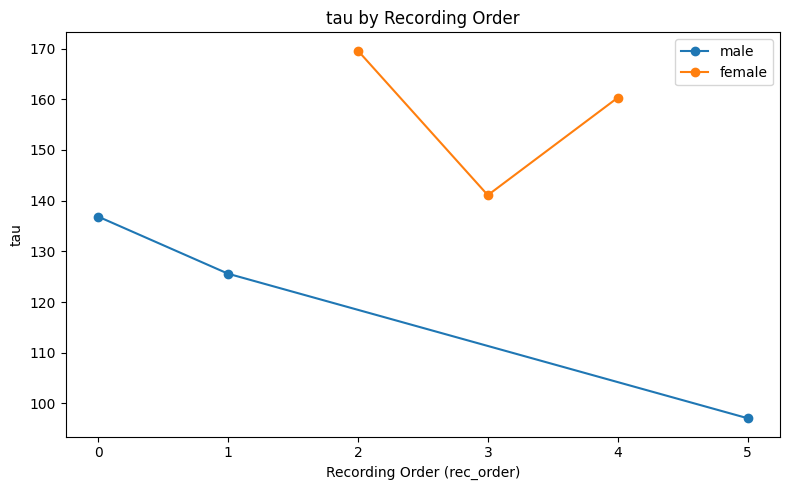

AUC (male): {0: 18846.249902777778, 1: 17238.18497222222, 5: 9447.599375}
AUC (female): {2: 8705.042104166667, 3: 11197.558500000001, 4: 11522.484125}


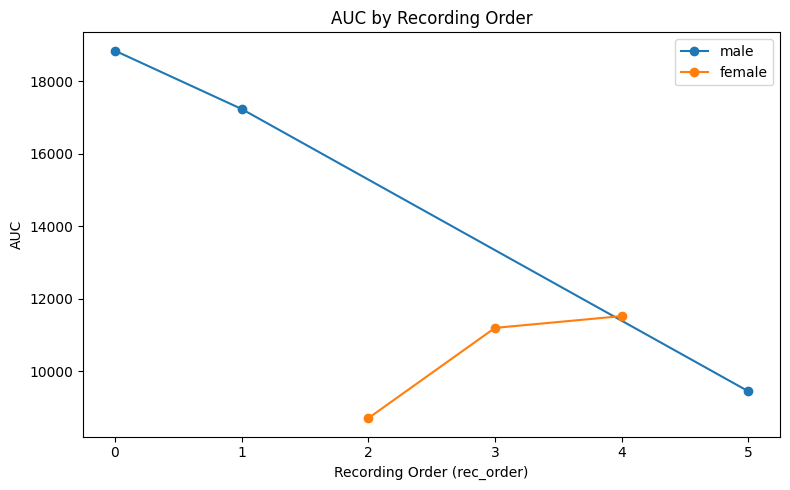


Mean Reaction metrics by recording order (rec_order):
reactionTime (male): {0: 10.504166666666666, 1: 9.925, 5: 10.066666666666666}
reactionTime (female): {2: 11.516666666666667, 3: 10.170833333333333, 4: 9.791666666666666}


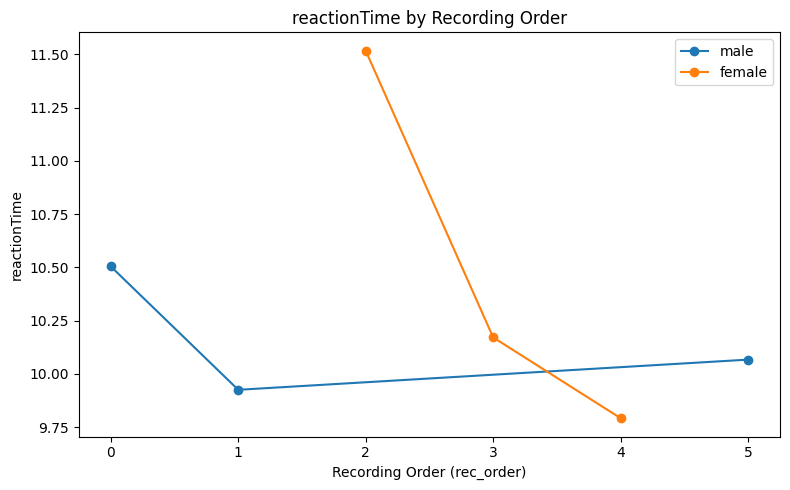

peakTime (male): {0: 31.304166666666667, 1: 32.40555555555555, 5: 28.2625}
peakTime (female): {2: 30.758333333333333, 3: 30.875, 4: 30.90833333333333}


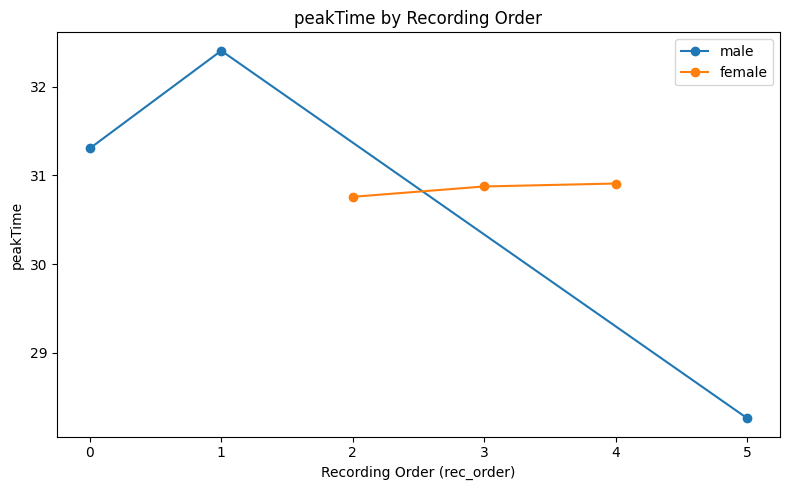

difference (male): {0: 20.8, 1: 22.480555555555554, 5: 18.195833333333333}
difference (female): {2: 19.241666666666667, 3: 20.704166666666666, 4: 21.116666666666667}


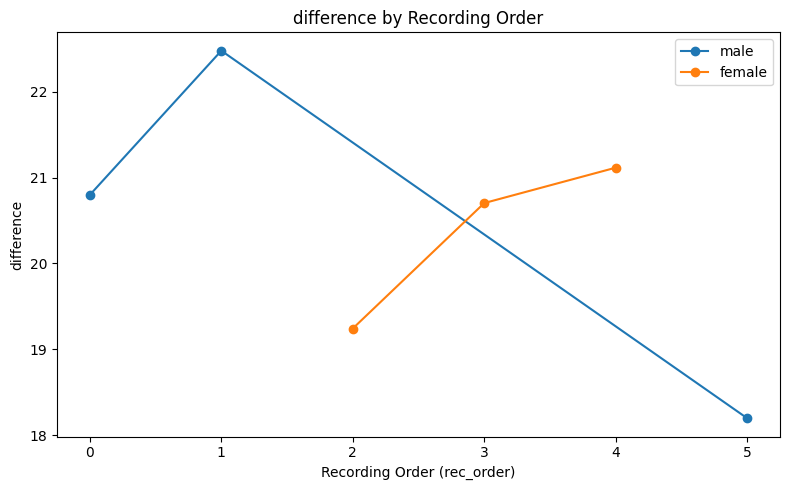


Change after second animal (rec_order=1):
peakValue (male): first=186.06, second=186.80, after_second_mean=123.69
peakValue (female): first=74.97, second=108.86, after_second_mean=97.40
RMS (male): first=48.89, second=48.01, after_second_mean=27.85
RMS (female): first=20.57, second=29.04, after_second_mean=27.37
tau (male): first=136.84, second=125.58, after_second_mean=97.08
tau (female): first=169.58, second=141.08, after_second_mean=160.30
AUC (male): first=18846.25, second=17238.18, after_second_mean=9447.60
AUC (female): first=8705.04, second=11197.56, after_second_mean=11522.48

Change after second animal (rec_order=1):
reactionTime (male): first=10.50, second=9.93, after_second_mean=10.07
reactionTime (female): first=11.52, second=10.17, after_second_mean=9.79
peakTime (male): first=31.30, second=32.41, after_second_mean=28.26
peakTime (female): first=30.76, second=30.88, after_second_mean=30.91
difference (male): first=20.80, second=22.48, after_second_mean=18.20
difference (f

In [337]:
# Analyze the shape of the effect of recording order on strength and reaction metrics

import matplotlib.pyplot as plt

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df = dfs['RESULTS_MERGED_DATE_EXP'].copy()
df['animal_num'] = df['animal'].apply(lambda x: int(''.join(filter(str.isdigit, x))) if isinstance(x, str) and x.lower().startswith('animal') else np.nan)
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

# Calculate means by rec_order for each metric and sex
for metrics, label in [(strength_metrics, "Strength"), (reaction_metrics, "Reaction")]:
    print(f"\nMean {label} metrics by recording order (rec_order):")
    for var in metrics:
        plt.figure(figsize=(8, 5))
        for sex in ['male', 'female']:
            means = df[df['sex'] == sex].groupby('rec_order')[var].mean()
            plt.plot(means.index, means.values, marker='o', label=f"{sex}")
            print(f"{var} ({sex}):", means.to_dict())
        plt.title(f"{var} by Recording Order")
        plt.xlabel("Recording Order (rec_order)")
        plt.ylabel(var)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Check if the change starts after the second animal
for metrics, label in [(strength_metrics, "Strength"), (reaction_metrics, "Reaction")]:
    print(f"\nChange after second animal (rec_order=1):")
    for var in metrics:
        for sex in ['male', 'female']:
            means = df[df['sex'] == sex].groupby('rec_order')[var].mean()
            if len(means) > 2:
                first = means.iloc[0]
                second = means.iloc[1]
                after_second = means.iloc[2:]
                print(f"{var} ({sex}): first={first:.2f}, second={second:.2f}, after_second_mean={after_second.mean():.2f}")

In [ ]:
print(dfs['RESULTS_MERGED_DATE'].head())

    animal     sex       experiment  reactionTime   peakTime  difference  \
0  Animal1  female      ASR_control     12.566667  34.300000   21.733333   
1  Animal1  female        gap_depth     11.566667  30.400000   18.833333   
2  Animal1  female  gap_duration_10     10.633333  31.366667   20.733333   
3  Animal1  female  gap_duration_20     11.200000  30.000000   18.800000   
4  Animal1  female   gap_duration_4     11.200000  30.133333   18.933333   

   peakValue        RMS         tau          AUC  
0  74.250000  20.153000  174.876333  8264.577000  
1  72.016667  19.371167  167.131500  8111.620833  
2  79.750000  22.228500  161.738833  9261.135833  
3  81.266667  22.431333  177.513333  9596.530000  
4  80.500000  22.053833  162.773500  9212.772500  


In [343]:
# Use the OVERVIEW DataFrame to get mean values for each variable and animal by recording order

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

# Load OVERVIEW DataFrame (replace with actual key if needed)
overview_key = [k for k in dfs.keys() if 'RESULTS_MERGED_DATE' in k.upper()][0]
overview_df = dfs[overview_key].copy()

# Extract animal number and rec_order
overview_df['animal_num'] = overview_df['animal'].apply(lambda x: int(''.join(filter(str.isdigit, str(x)))) if isinstance(x, str) and x.lower().startswith('animal') else np.nan)
overview_df = overview_df[overview_df['animal_num'].isin(recording_order)]
overview_df['rec_order'] = overview_df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

rec_order_indices = list(range(len(recording_order)))

print("\n--- means by recording order ---\n")
for metrics, label in [(strength_metrics, "Strength"), (reaction_metrics, "Reaction")]:
    for var in metrics:
        means = overview_df.groupby('rec_order')[var].mean().reindex(rec_order_indices).apply(lambda x: f"{x:.2f}" if not pd.isna(x) else "")
        print(f"{var}: {dict(zip(rec_order_indices, means))}")


--- OVERVIEW means by recording order ---

peakValue: {0: '186.06', 1: '186.80', 2: '74.97', 3: '108.86', 4: '97.40', 5: '123.69'}
RMS: {0: '48.89', 1: '48.01', 2: '20.57', 3: '29.04', 4: '27.37', 5: '27.85'}
tau: {0: '136.84', 1: '125.58', 2: '169.58', 3: '141.08', 4: '160.30', 5: '97.08'}
AUC: {0: '18846.25', 1: '17238.18', 2: '8705.04', 3: '11197.56', 4: '11522.48', 5: '9447.60'}
reactionTime: {0: '10.50', 1: '9.93', 2: '11.52', 3: '10.17', 4: '9.79', 5: '10.07'}
peakTime: {0: '31.30', 1: '32.41', 2: '30.76', 3: '30.88', 4: '30.91', 5: '28.26'}
difference: {0: '20.80', 1: '22.48', 2: '19.24', 3: '20.70', 4: '21.12', 5: '18.20'}


## Summary of Recording Order Effects

### Shape and Onset of Effect

- **Strength metrics** (peakValue, RMS, tau, AUC) **decrease** as recording order increases.
- **Reaction metrics** (reactionTime, peakTime, difference) **increase** with recording order.
- The **change starts after the second animal** (rec_order=1):  
  - The first two animals have higher strength and lower reaction times.
  - Animals recorded third and later show a marked drop in strength and increase in reaction metrics.

---

### Interpretation

- **Step-like change:** After the second animal, strength drops and reaction time rises, then plateaus or changes gradually.
- **Consistent across sexes:** Both males and females show this pattern.
- **Order/time-of-day effect is strong:** Later animals in the session have lower strength and slower reactions.

---

### Mean Values by Recording Order

| rec_order | peakValue | RMS   | tau    | AUC      |
|-----------|-----------|-------|--------|----------|
| 0         | 186.06    | 48.89 | 136.84 | 18846.25 |
| 1         | 186.80    | 48.01 | 125.58 | 17238.18 |
| 2         | 74.97     | 20.57 | 169.58 | 8705.04  |
| 3         | 108.86    | 29.04 | 141.08 | 11197.56 |
| 4         | 97.40     | 27.37 | 160.30 | 11522.48 |
| 5         | 123.69    | 27.85 | 97.08  | 9447.60  |

| rec_order | reactionTime | peakTime | difference |
|-----------|--------------|----------|------------|
| 0         | 10.50        | 31.30    | 20.80      |
| 1         | 9.93         | 32.41    | 22.48      |
| 2         | 11.52        | 30.76    | 19.24      |
| 3         | 10.17        | 30.88    | 20.70      |
| 4         | 9.79         | 30.91    | 21.12      |
| 5         | 10.07        | 28.26    | 18.20      |
---

### -> where did the reaction time increase go

## Plots

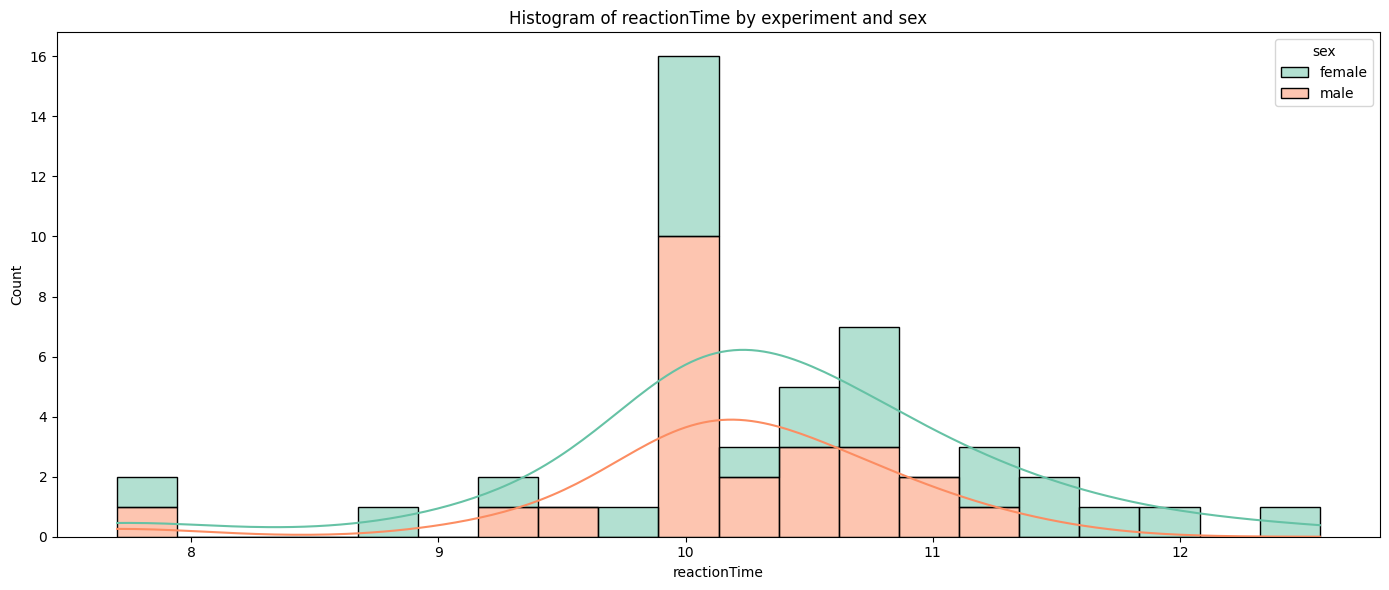

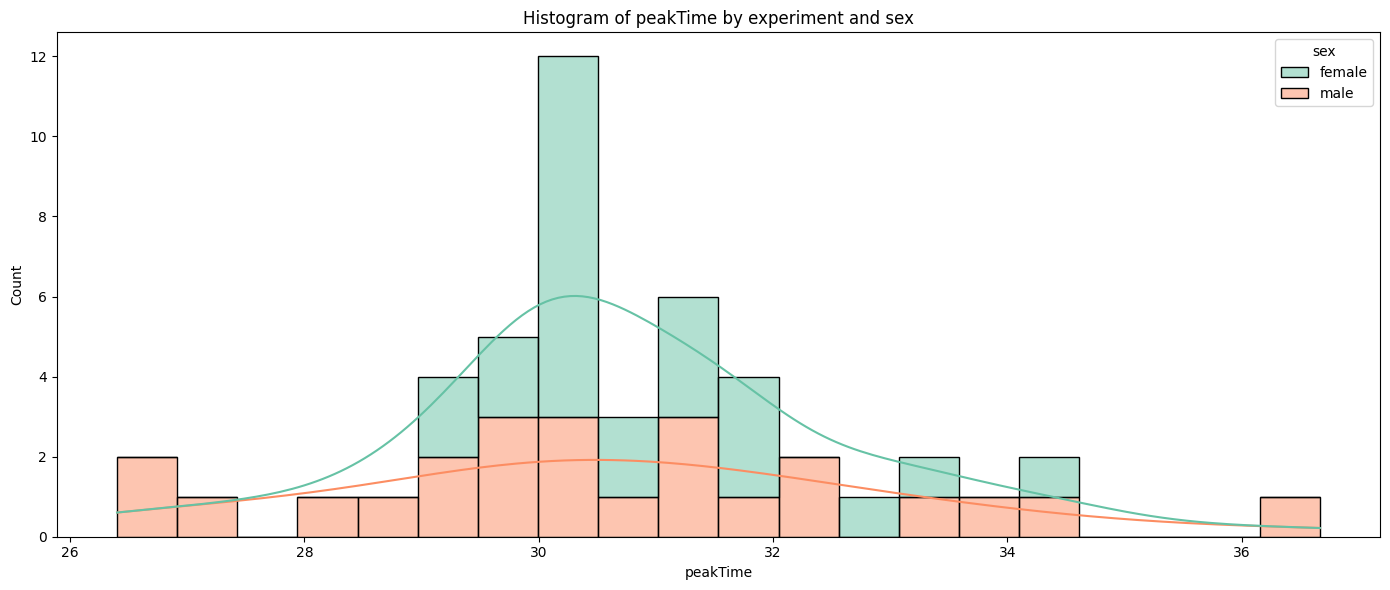

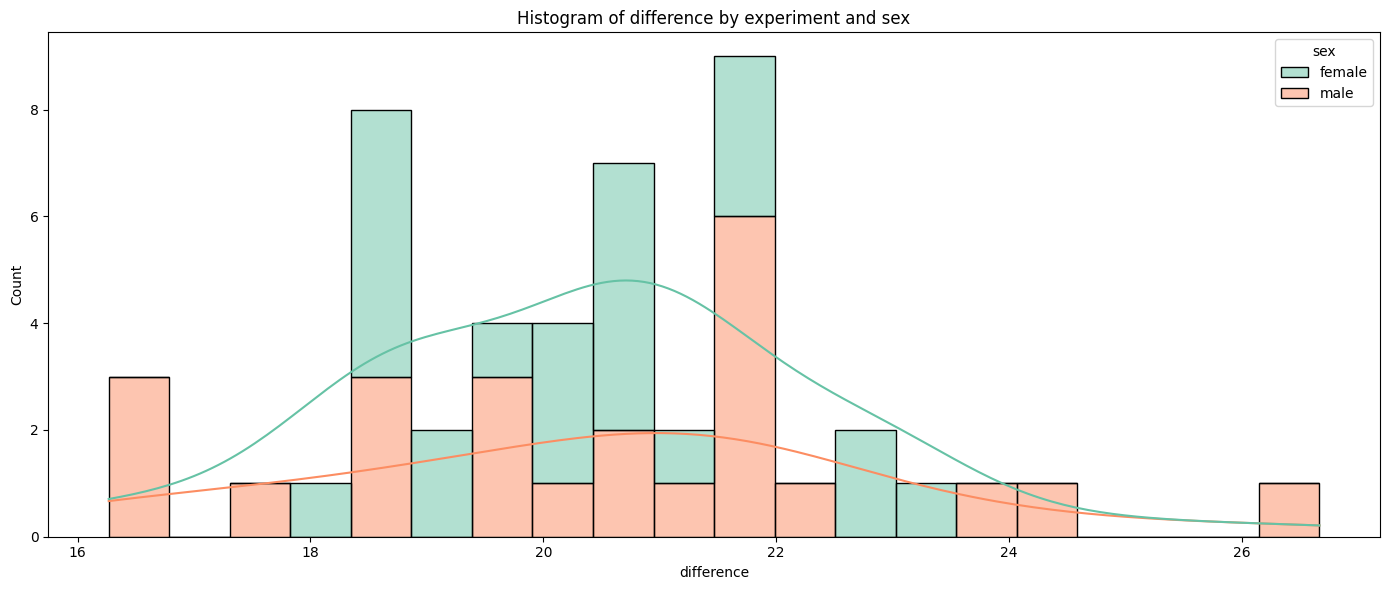

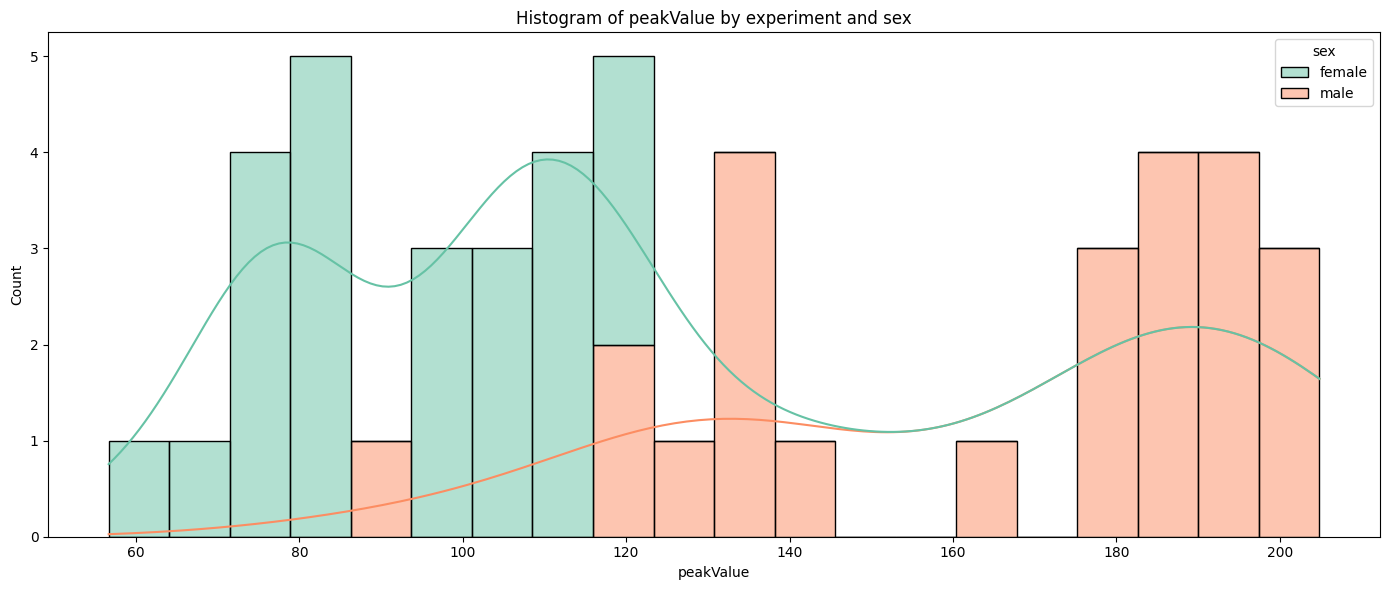

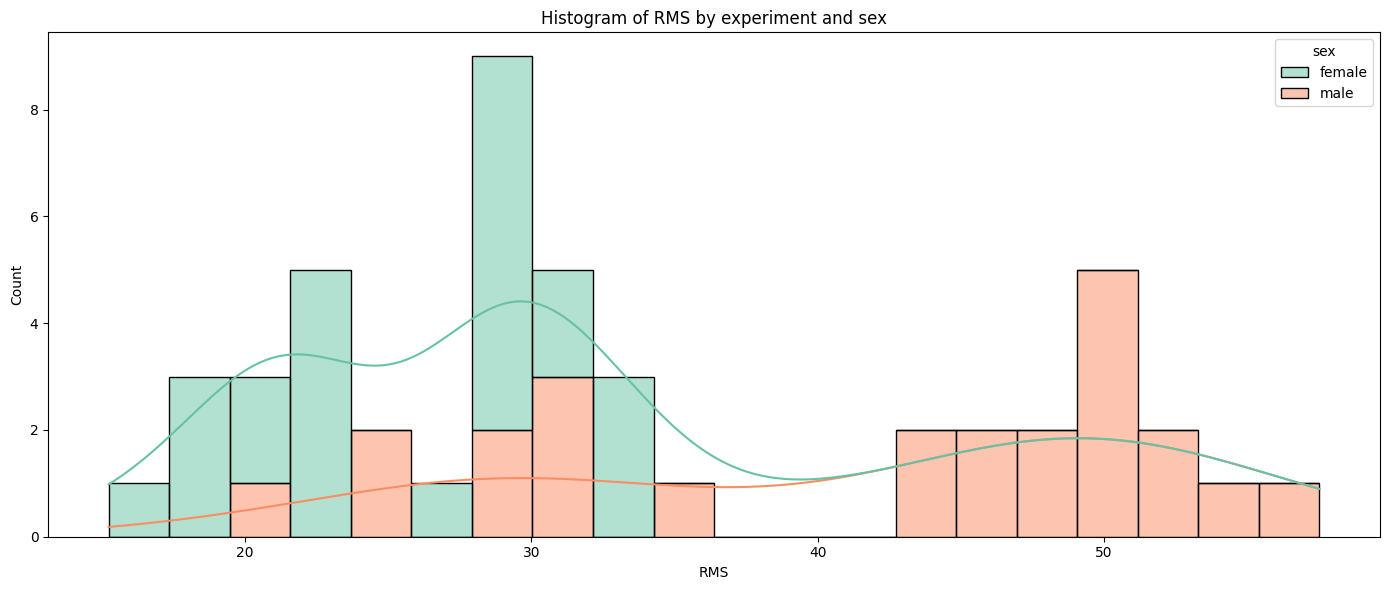

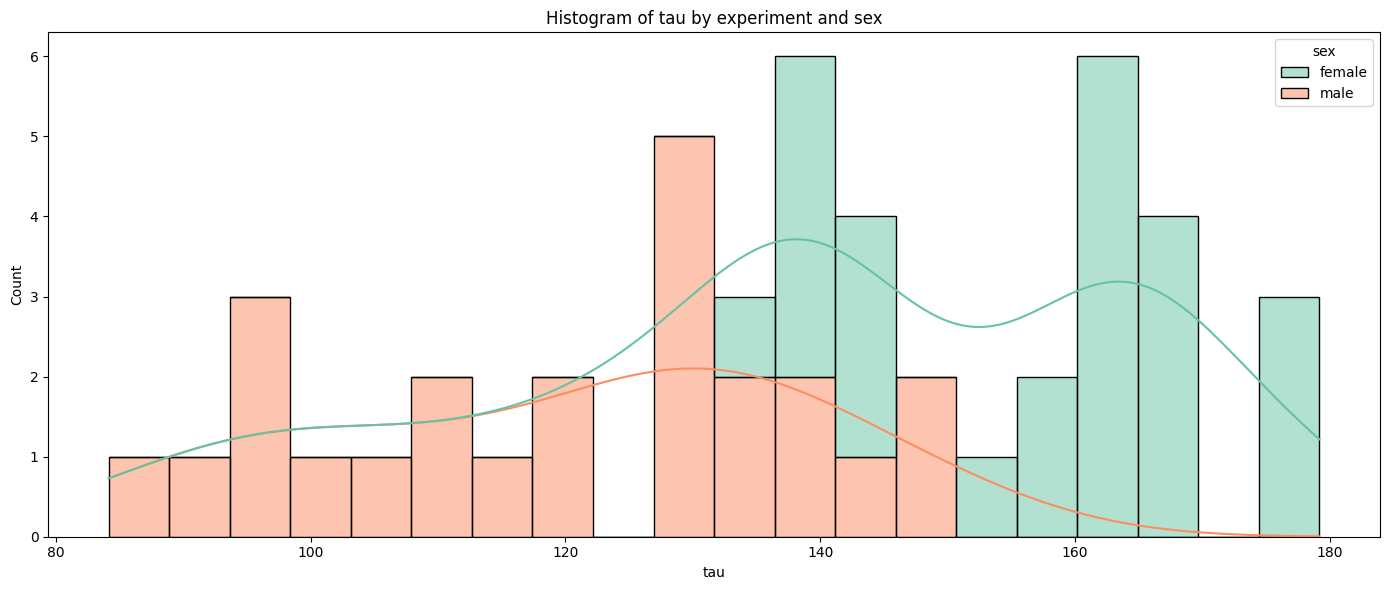

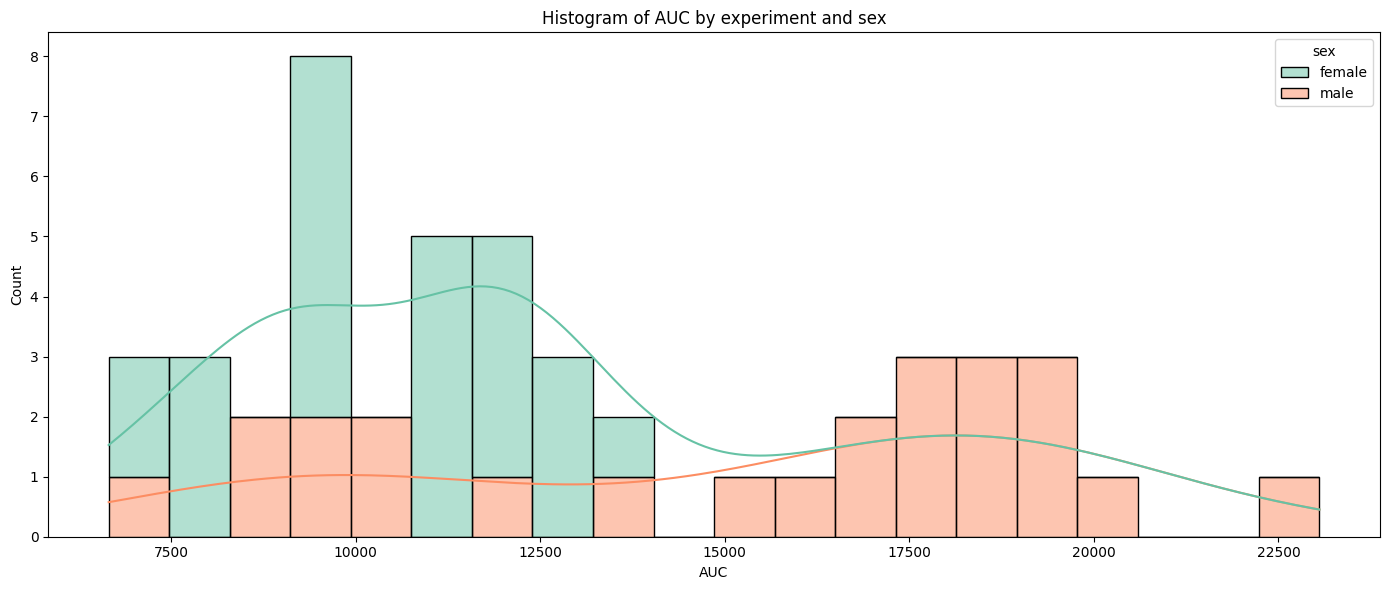

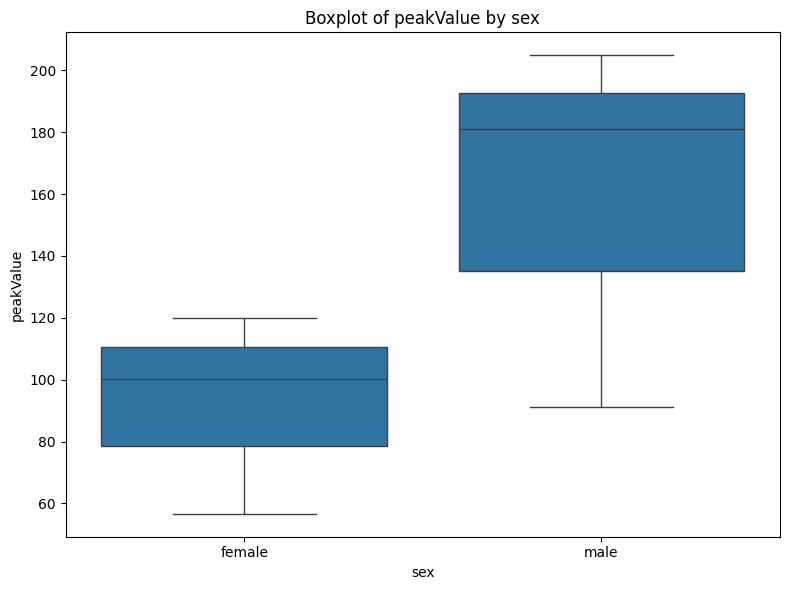

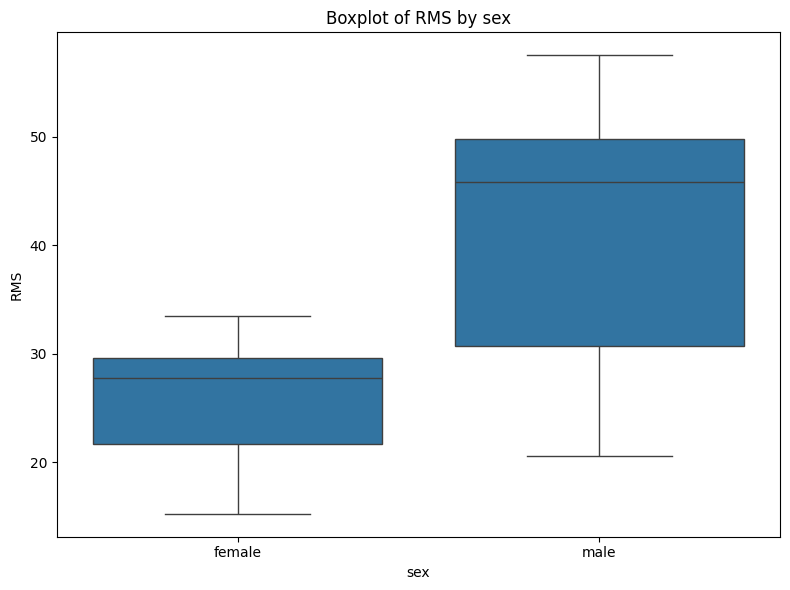

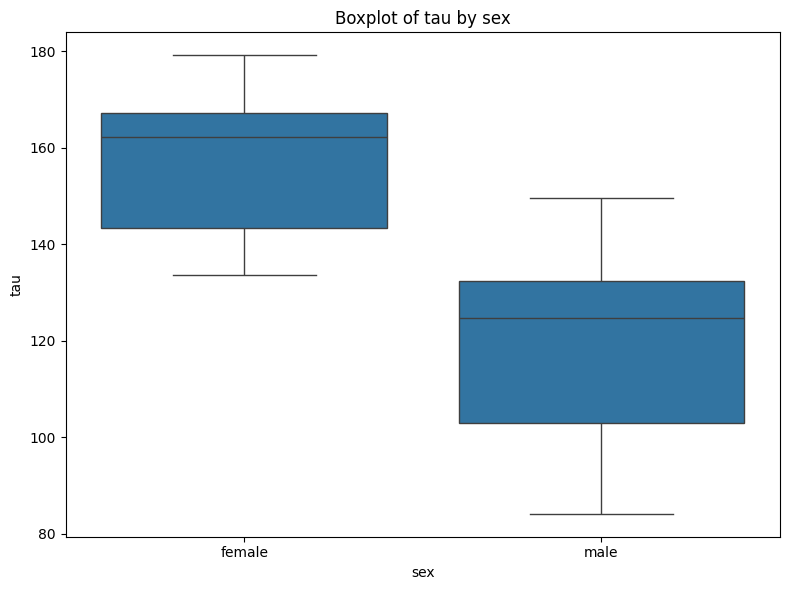

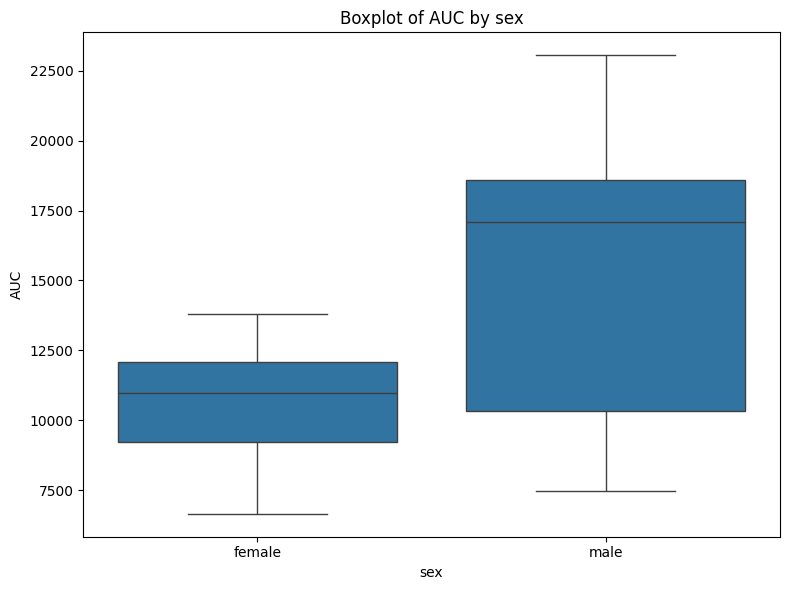

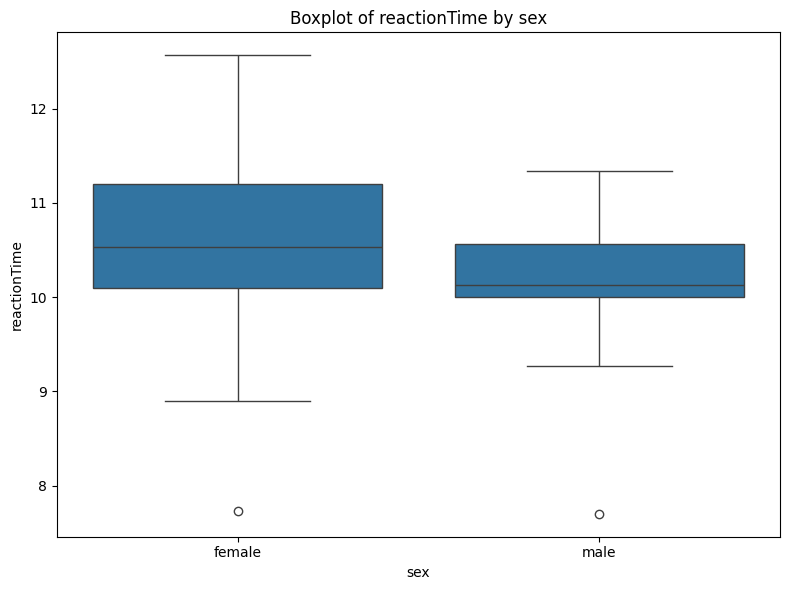

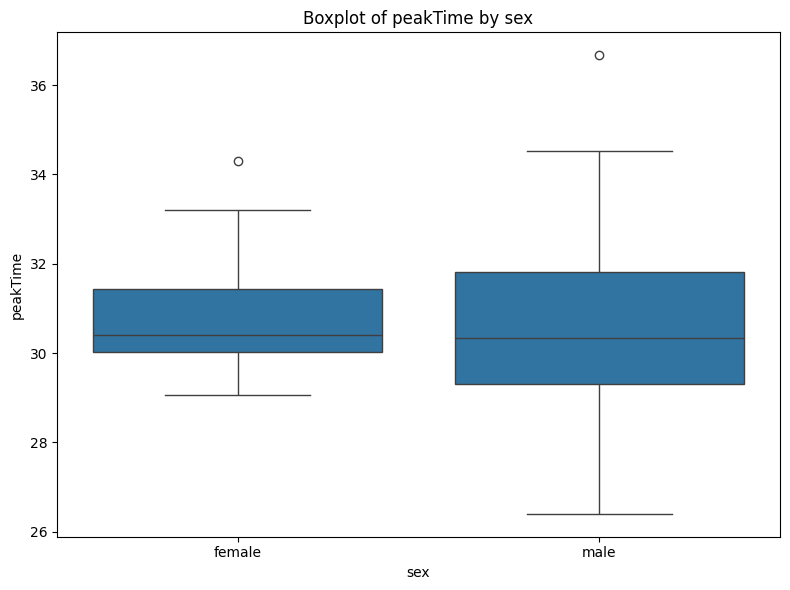

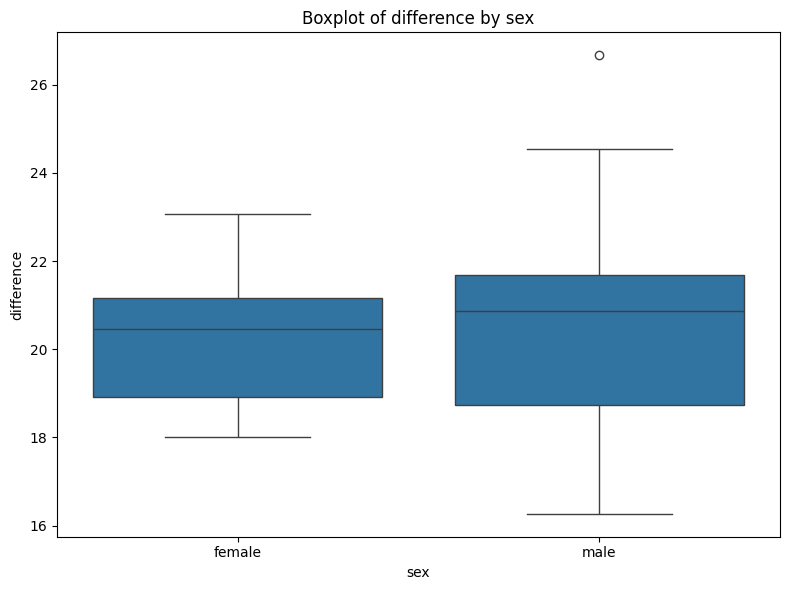

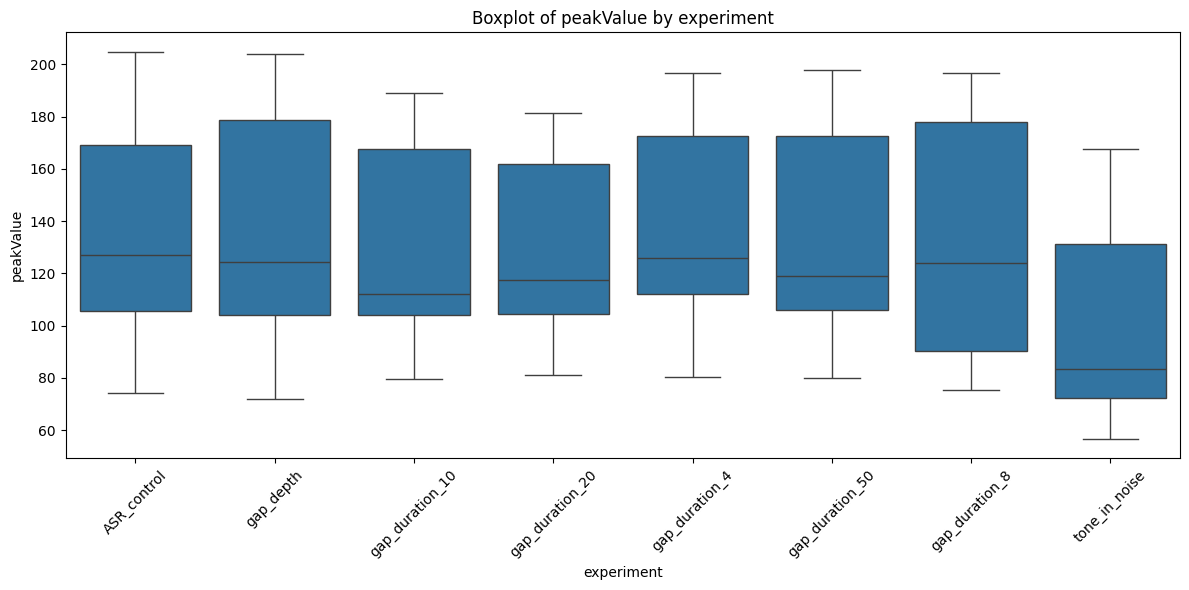

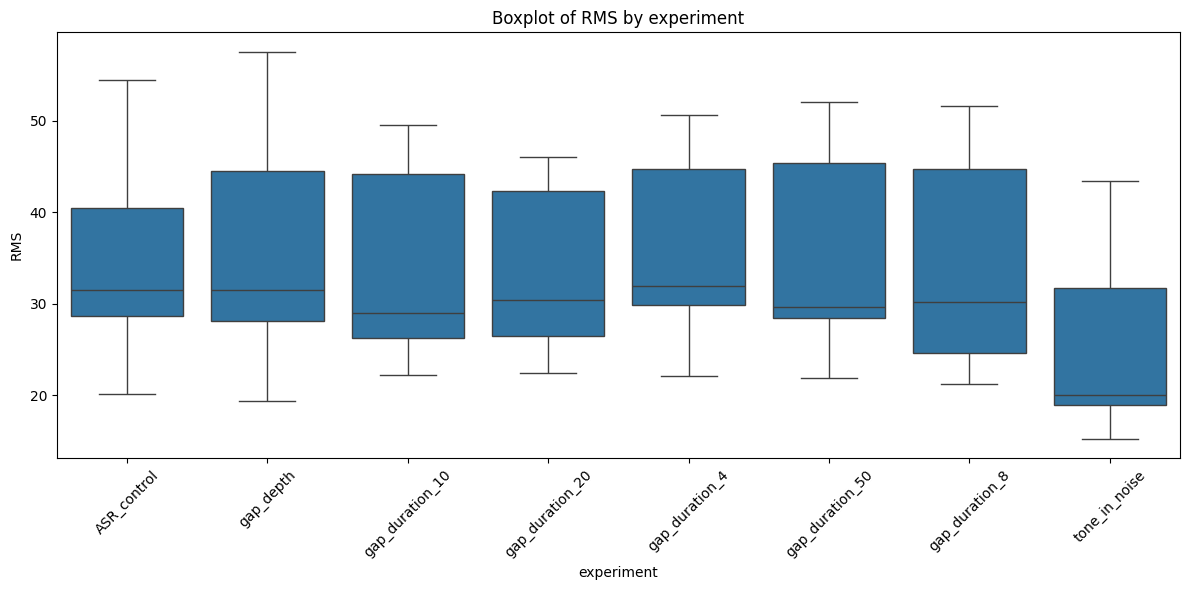

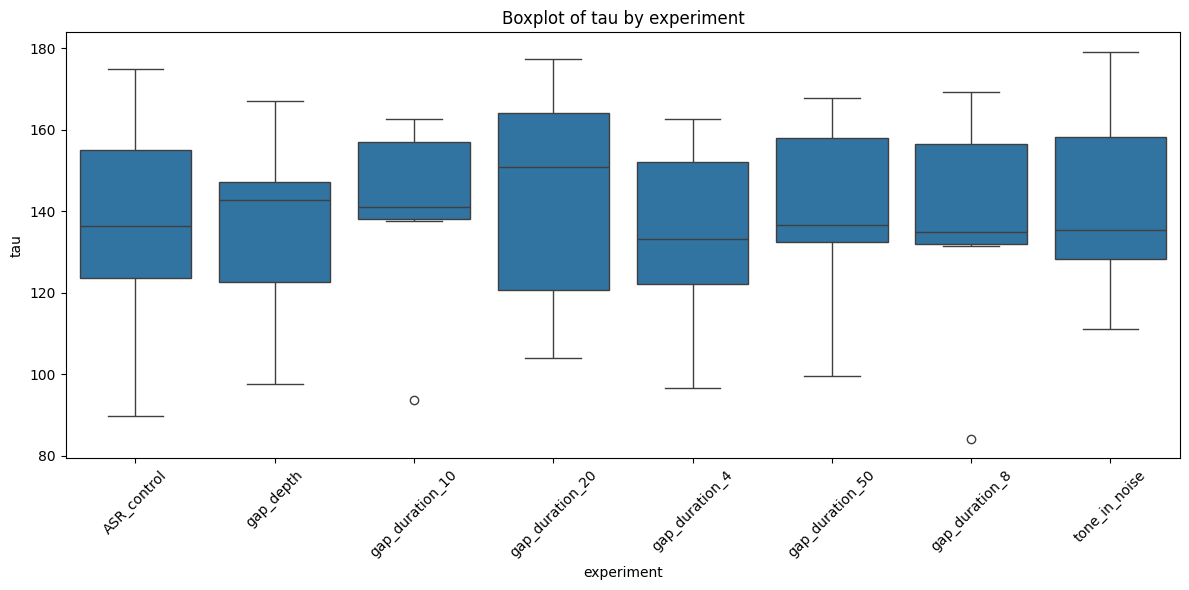

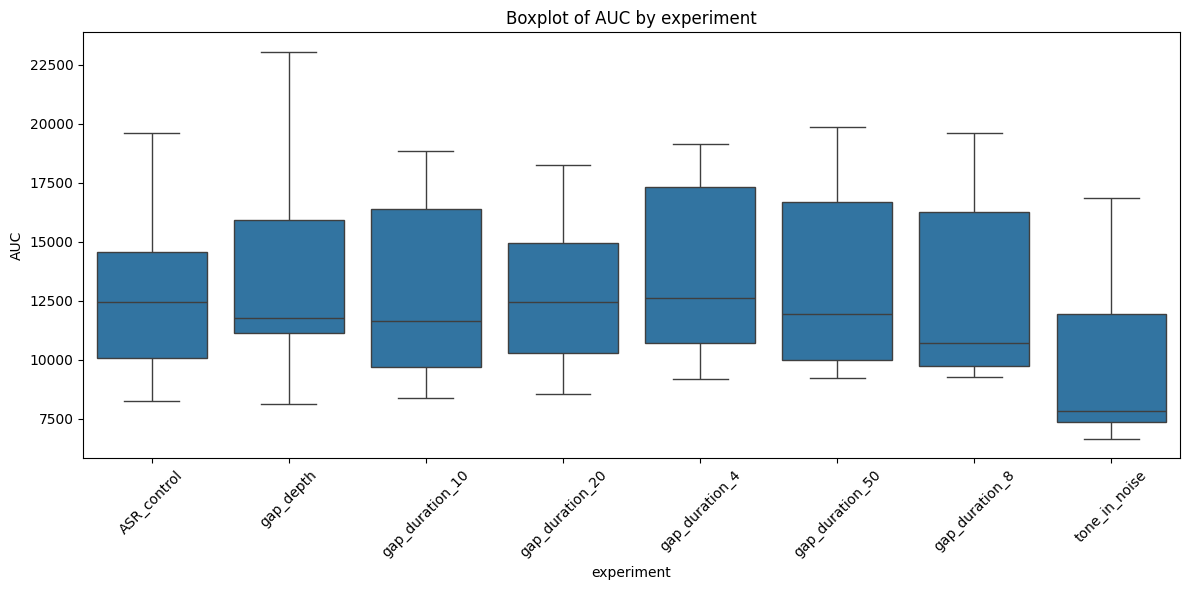

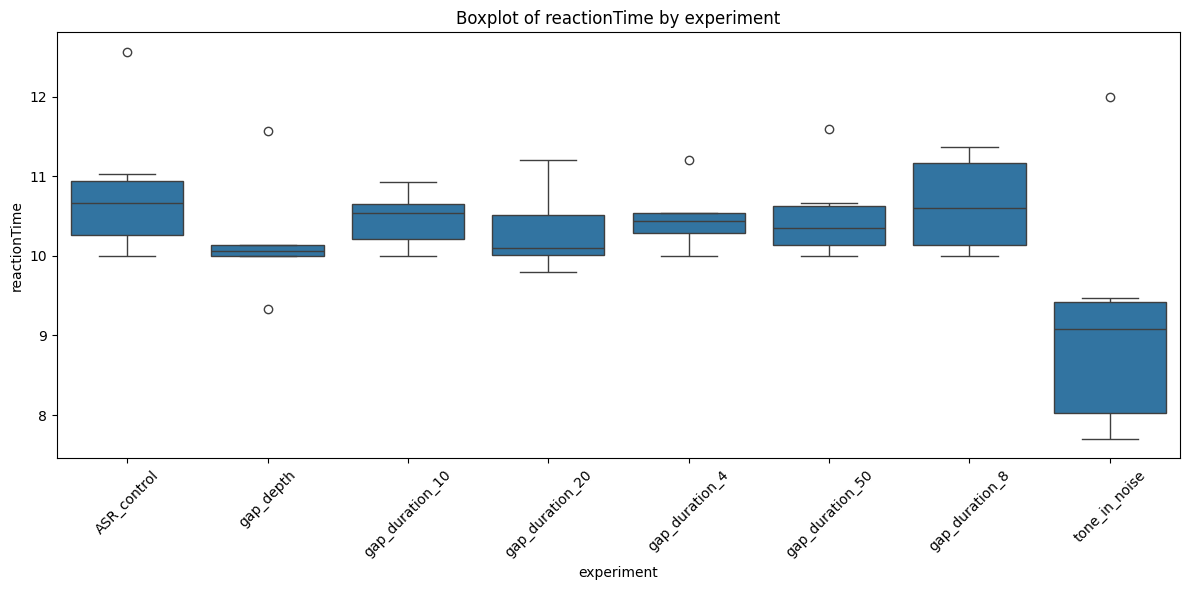

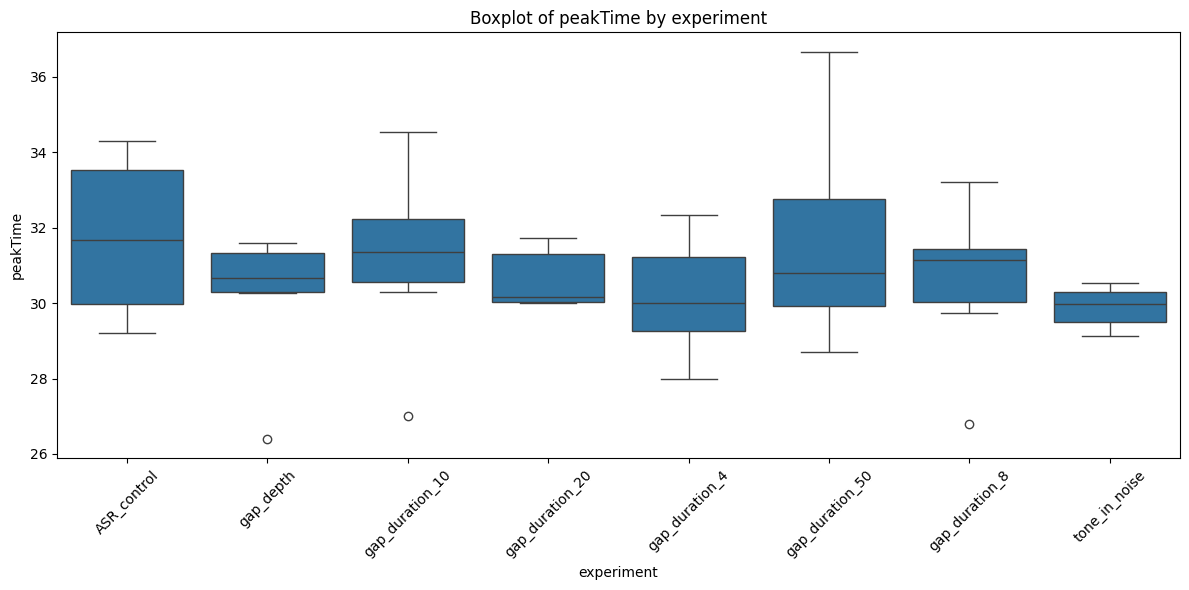

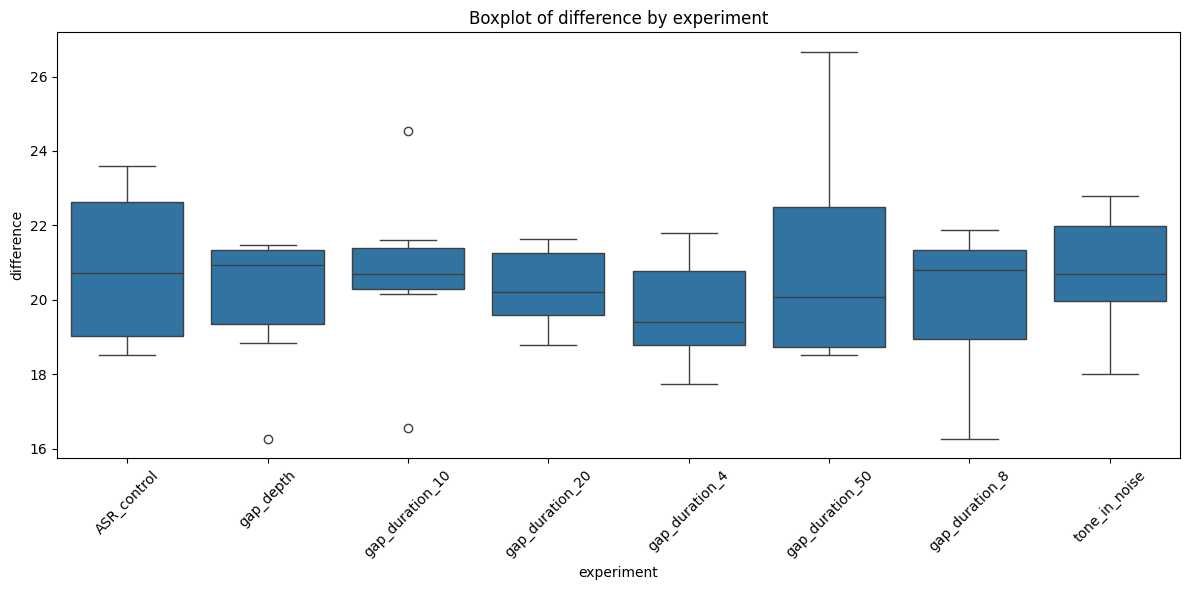

In [ ]:
# --- Useful plots for distributions, sex differences, and experiment differences ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histogram plots for each variable, split by experiment and sex
def plot_histograms(df, variables, group_col='experiment', split_col='sex', bins=20):
    for var in variables:
        plt.figure(figsize=(14, 6))
        ax = sns.histplot(
            data=df,
            x=var,
            hue=split_col,
            multiple="stack",
            bins=bins,
            kde=True,
            palette="Set2"
        )
        plt.title(f'Histogram of {var} by {group_col} and {split_col}')
        plt.xlabel(var)
        plt.ylabel('Count')
        # Add legend only if there are handles
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            plt.legend(title=split_col)
        plt.tight_layout()
        plt.show()


# 2. Boxplots for sex differences (strength and reaction metrics)
def plot_sex_differences(df, metrics, group_col='sex'):
    for var in metrics:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x=group_col, y=var)
        plt.title(f'Boxplot of {var} by {group_col}')
        plt.tight_layout()
        plt.show()

# 3. Boxplots for experiment differences (strength and reaction metrics)
def plot_experiment_differences(df, metrics, group_col='experiment'):
    for var in metrics:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=group_col, y=var)
        plt.title(f'Boxplot of {var} by {group_col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_histograms(dfs['RESULTS_MERGED_DATE'], variables)
plot_sex_differences(dfs['RESULTS_MERGED_DATE'], strength_metrics + reaction_metrics)
plot_experiment_differences(dfs['RESULTS_MERGED_DATE'], strength_metrics + reaction_metrics)